# 01. Quickstart

This is tested on Python 3.6 on Ubuntu 18.04, using tensorflow 1.12. Code is based on https://github.com/ur-whitelab/hoomd-tf#quickstart-tutorial

In [1]:
# (Optional) This block is to surpress the warning on loading tensorflow package
import warnings
warnings.filterwarnings('ignore')

In [2]:
import hoomd
import hoomd.htf as htf
import tensorflow as tf

In [3]:
########### Graph Building Code ###########
graph = htf.graph_builder(8, output_forces=True) # max neighbors = 64
pair_energy = graph.nlist_rinv # nlist_rinv is neighbor 1 / r
particle_energy = tf.reduce_sum(pair_energy, axis=1) # sum over neighbors
forces = graph.compute_forces(particle_energy) # compute forces
rdf = graph.compute_rdf([3, 5], 'rdf', 20, 0, 0) # compute RDF
graph.save_tensor(rdf, name='rdf-00')
avg_rdf = graph.running_mean(rdf, 'avg-rdf') 
graph.save('my_model', forces)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [4]:
########### Hoomd-Sim Code ################
hoomd.context.initialize("--mode=cpu")
# this will start TensorFlow, so it goes
# in a with statement for clean exit.
#
# if calling initialize() without params, 
# it will be throw error of using unexpected parameter 'f'
# ref: https://github.com/glotzerlab/hoomd-blue/blob/master/hoomd/context.py#L204
with htf.tfcompute('my_model') as tfcompute:
    # create a square lattice
    rcut = 5
    system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sq(a=4.0),
                                        n=[3,3])
    nlist = hoomd.md.nlist.cell()
    hoomd.md.integrate.mode_standard(dt=0.005)
    hoomd.md.integrate.nve(group=hoomd.group.all())
    tfcompute.attach(nlist, r_cut=rcut)
    hoomd.run(1e3)

HOOMD-blue v2.5.1 CUDA (10.0) SINGLE SSE SSE2 
Compiled: 03/07/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
notice(2): NVIDIA driver not installed or is too old, ignoring any GPUs in the system.
HOOMD-blue is running on the CPU
notice(2): Started TF Session Manager.
notice(2): Group "all" created containing 9 particles
notice(2): Force mode is FORCE_MODE.tf2hoomd 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate
notice(2): Setting flag indicating virial mo

INFO:tensorflow:Restoring parameters from my_model/model-1000


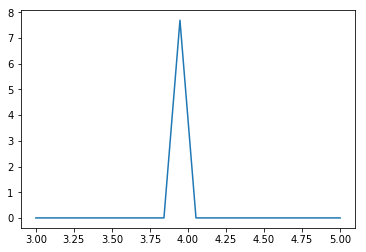

In [6]:
import matplotlib.pyplot as plt
import numpy as np 

r = np.linspace(3, 5, 20)
variables = htf.load_variables('my_model', ['rdf-00', 'avg-rdf'])
plt.plot(r, variables['rdf-00'])
plt.show()